# <span style="font-size:40px;">Customer segmentation</span>

---

This notebook demonstrates the process of solving problems related to customer segmentation.
It includes 
- [Exploratory Data Analysis (EDA)](#EDA)
- [Modeling](#Modeling)
- [Prediction](#Prediction)
- [Model Explain](#Model-Explain)

---


<span style="font-size:25px;">[Exploratory Data Analysis (EDA)](#EDA)</span>

The information obtained from Exploratory Data Analysis (EDA) is as follows: <br>

[Basic information](#Basic-information)
- The data consists of 11 columns. 1 key column, 1 target column, 10 features
- The training set contains 8068 rows. The testing set contains 2627 rows. There are no duplicate data entries, and each ID corresponds to one row.
- There are null value in some column. work_experience have null 10% , family_size have null 4% <br> These two columns might impact the accuracy of the model. During the model training process, it might be necessary to experiment with different approaches.

[Label](#Label)
- Each label has a similar proportion of data. so there's no need to worry about imbalance data problem.

[Feature](#Feature)
- [Gender](#Gender) : Every group has an equal gender proportion.
- [Ever married](#Ever-married) : Group D has a higher proportion of individuals who have never been married compared to other groups.
- [Age](#Age) :  While other groups have an average age of 40+, Group D has an average age of 29.
- [Graduated](#Graduated) : 
    - Group C has the highest graduation rate at 82%
    - Group B has the lowest graduation rate at 36%
- [Profession](#Profession) : In Group D, the proportions of customer in healthcare and marketing are noticeably higher than in other groups.
- [Work experience](#Work-experience)  : There is no difference between the groups.
- [Spending score](#Spending-score) : 
  - Group C has a relatively higher average proportion, 
  - Group D has a significantly higher proportion of "low" compared to the other groups.
- [Family size](#Family-size) :
  - Group C has a smaller proportion of size 1 compared to other groups. 
  - Group D has a higher proportion of size 2 compared to the other groups.
- [var_1](#var_1) : I still don't see a clear difference. 

<span style="font-size:15px;"><b>From the data we have, we can guess that the model might predict Group D quite well,<br> 
    but Group C might be predicted with slightly lower accuracy.<br> 
    However, predicting Groups A and B accurately could be a bit challenging.</b></span>

---

<span style="font-size:25px;">[Modeling](#Modeling)</span>

[LightGBM](#LightGBM)

I'm starting with the LightGBM model because of its strong track record in handling tabular data.<br>
From my experience and the feedback within the community, LightGBM tends to outperform other models for this type of data.

Version 1 <br>
The results are as showed, with an accuracy of 0.52. However, as anticipated, Group D has a relatively high accuracy, around 0.72.

Version 2 <br>
Since I wasn't satisfied with the results from version 1, I decided to try removing features that could potentially lead to overfitting. 
<br>I attempted to eliminate features with high importance in version 1, which coincidentally aligns with the issue of null values.

Version 3 <br>
The results from version 2 were still not good enough.<br> 
So, I tried to make changes to the features to help the model better understand the differences between each group, from a clearer perspective.

[Decision Tree](#Decision-Tree)<br>

Since I thought that LightGBM, being an ensemble model, might be over engineer for this problem, I decided to try using a single decision tree. However, the results were slightly worse than LightGBM.

[SVM](#SVM)<br>

Since the previous two models didn't meet expectations, I decided to give Support Vector Machines (SVM) a try, hoping it might be more suitable for this particular problem.<br>
The results were slightly worse than previous versions.

[AutoML](#AutoML)<br>
Since trying the previous models didn't lead to improved accuracy, I decided to experiment with AutoML to see if there's any model that AutoML can suggest to increase accuracy.

<span style="font-size:20px;">How I choose final model</span><br>
As seen on the [AutoGluon leaderboard](#Leaderboard) <br>

the top 3 performing models are WeightedEnsemble_L2, CatBoost, and XGBoost.<br>
Each model performs well in different classes.<br>
Since the task didn't specify whether we should focus on precision or recall for any particular class, and accuracy is also balanced, 
<br>I decided to base my decision on the training and prediction times. 
<br>It turns out that XGBoost has the shortest runtime, so I chose XGBoost.

[Diagnostic](#Diagnostic)<br>
Because the model isn't good at predicting Groups A and B, I tried to find what makes them different from the other groups.<br>
I noticed that some rows in the data have the same features but belong to different groups.<br>
This could mean there's a mistake or issue with the data.<br>
Or the data andfeatures might not be sufficient to distinguish them.<br>

---

<span style="font-size:25px;">[Prediction](#Prediction)</span>

[Cross Validation](#CrossValidation)<br>
Before I make predictions, I want to be sure the model can work well with new data.<br> 
So, that's why I performed cross-validation.<br> 
The results showed that the model provided similar accuracy across all folds.<br> 
This gives me some confidence that if the model encounters new data, it's likely to perform consistently well.

---

<span style="font-size:25px;">[Model Explain](#Model-Explain)</span>

[Feature importance](#Feature-importance)<br>
Provide an overview of how different features affect the target groups, showing which features have a significant impact and in what direction.

[Specific customer](#Specific-customer)<br>
You can see why the model thinks a customer belongs to a particular group by looking at each customer individually.

---

# Import lib

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [2]:
# Preprocess data
import category_encoders as ce
from sklearn.model_selection import train_test_split

# Model
import lightgbm
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from autogluon.tabular import TabularDataset, TabularPredictor
from sklearn.model_selection import StratifiedKFold

# Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Model interpret
import shap

In [3]:
df_train = pd.read_csv('customer_segmentation_train.csv')
df_test = pd.read_csv('customer_segmentation_test.csv')

# EDA

In [4]:
df_train = pd.read_csv('customer_segmentation_train.csv')
df_test = pd.read_csv('customer_segmentation_test.csv')

## Basic information

In [5]:
df_train.shape
df_train.head()

(8068, 11)

,id,gender,ever_married,age,graduated,profession,work_experience,spending_score,family_size,var_1,segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A


In [6]:
df_train.dtypes

id                   int64
gender              object
ever_married        object
age                  int64
graduated           object
profession          object
work_experience    float64
spending_score      object
family_size        float64
var_1               object
segmentation        object
dtype: object

In [7]:
# See that data is one rows for one customer
df_train.shape
df_train['id'].nunique()

(8068, 11)

8068

In [8]:
# See that data is one rows for one customer
df_test.shape
df_test['id'].nunique()

(2627, 10)

2627

### Check duplicate rows
* There is no duplicate rows

In [9]:
df_train_dup_row = df_train[df_train.duplicated()]
print(f"Number of duplicate rows: {df_train_dup_row.shape[0]}")

Number of duplicate rows: 0


### Check null value
* work_experience have null 10%
* family_size have null 4%

In [10]:
df_null_val = df_train.isnull().sum().reset_index()
df_null_val.columns = ['feature', 'count_null']

df_null_val['percentage_null'] = 100 * df_null_val['count_null'] / df_train.shape[0]
df_null_val

,feature,count_null,percentage_null
0,id,0,0.000000
1,gender,0,0.000000
2,ever_married,140,1.735250
3,age,0,0.000000
4,graduated,78,0.966782
5,profession,124,1.536936
6,work_experience,829,10.275161
7,spending_score,0,0.000000
8,family_size,335,4.152206
9,var_1,76,0.941993


In [11]:
df_null_val = df_test.isnull().sum().reset_index()
df_null_val.columns = ['feature', 'count_null']

df_null_val['percentage_null'] = 100 * df_null_val['count_null'] / df_train.shape[0]
df_null_val

,feature,count_null,percentage_null
0,id,0,0.000000
1,gender,0,0.000000
2,ever_married,50,0.619732
3,age,0,0.000000
4,graduated,24,0.297471
5,profession,38,0.470997
6,work_experience,269,3.334160
7,spending_score,0,0.000000
8,family_size,113,1.400595
9,var_1,32,0.396629


## Label
* Each label has a similar proportion of data.

In [12]:
df_train['segmentation'].value_counts().sort_index()

segmentation
A    1972
B    1858
C    1970
D    2268
Name: count, dtype: int64

In [13]:
df_train['segmentation'].value_counts(normalize=True).sort_index()*100

segmentation
A    24.442241
B    23.029251
C    24.417452
D    28.111056
Name: proportion, dtype: float64

## Feature

### Gender
* Every group has an equal gender proportion.

In [14]:
df_gender = df_train.groupby(['segmentation'])['gender'].value_counts().reset_index()
df_count_segmentation = df_train.groupby(['segmentation']).agg(count_seg=('segmentation', 'count')).reset_index()
df_gender = df_gender.merge(df_count_segmentation, on=['segmentation'], how='left')
df_gender['gender_percentage'] = 100 * df_gender['count'] / df_gender['count_seg']

In [15]:
df_gender

,segmentation,gender,count,count_seg,gender_percentage
0,A,Male,1063,1972,53.904665
1,A,Female,909,1972,46.095335
2,B,Male,997,1858,53.659849
3,B,Female,861,1858,46.340151
4,C,Male,1048,1970,53.197970
5,C,Female,922,1970,46.802030
6,D,Male,1309,2268,57.716049
7,D,Female,959,2268,42.283951


<Figure size 800x400 with 0 Axes>

<Axes: xlabel='segmentation', ylabel='gender_percentage'>

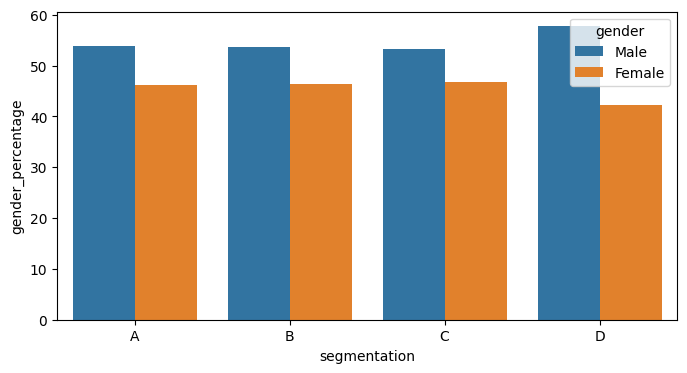

In [16]:
plt.figure(figsize=(8, 4))
sns.barplot(x="segmentation", y="gender_percentage", hue="gender", data=df_gender)

### Ever married
* Group D has a higher proportion of individuals who have never been married compared to other groups.

In [17]:
df_married = df_train[df_train['ever_married'].notna()]
df_count_segmentation = df_married.groupby(['segmentation']).agg(count_seg=('segmentation', 'count')).reset_index()

df_married= df_married.groupby(['segmentation'])['ever_married'].value_counts().reset_index()
df_married = df_married.merge(df_count_segmentation, on=['segmentation'], how='left')
df_married['merried_percentage'] = 100 * df_married['count'] / df_married['count_seg']

In [18]:
df_married

,segmentation,ever_married,count,count_seg,merried_percentage
0,A,Yes,1137,1938,58.668731
1,A,No,801,1938,41.331269
2,B,Yes,1348,1827,73.782157
3,B,No,479,1827,26.217843
4,C,Yes,1549,1947,79.558295
5,C,No,398,1947,20.441705
6,D,No,1607,2216,72.518051
7,D,Yes,609,2216,27.481949


<Figure size 800x400 with 0 Axes>

<Axes: xlabel='segmentation', ylabel='merried_percentage'>

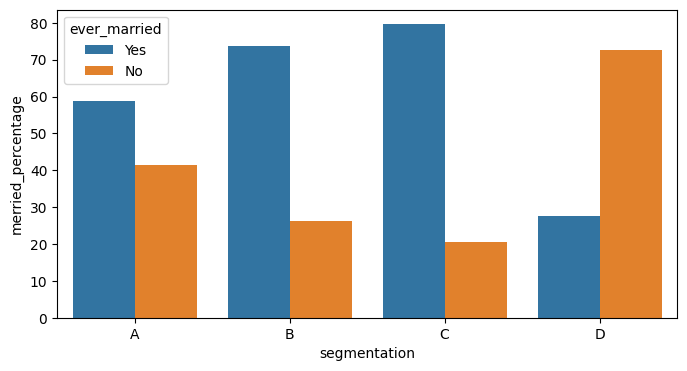

In [19]:
plt.figure(figsize=(8, 4))
sns.barplot(x="segmentation", y="merried_percentage", hue="ever_married", data=df_married)

### Age
* While other groups have an average age of 40+, Group D has an average age of 29.

In [20]:
df_age = df_train.groupby('segmentation')['age'].median().reset_index()
df_age

,segmentation,age
0,A,41.0
1,B,46.0
2,C,49.0
3,D,29.0


<Figure size 800x400 with 0 Axes>

<Axes: xlabel='segmentation', ylabel='age'>

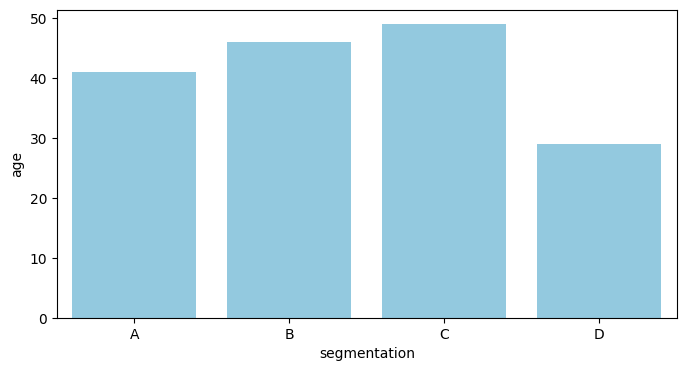

In [21]:
plt.figure(figsize=(8, 4))
sns.barplot(x="segmentation", y="age", data=df_age, color='skyblue')

### Graduated
* Group C has the highest graduation rate at 82%
* Group B has the lowest graduation rate at 36%

In [22]:
df_grad = df_train[df_train['graduated'].notna()]
df_count_segmentation = df_grad.groupby(['segmentation']).agg(count_seg=('segmentation', 'count')).reset_index()

df_grad= df_grad.groupby(['segmentation'])['graduated'].value_counts().reset_index()
df_grad = df_grad.merge(df_count_segmentation, on=['segmentation'], how='left')
df_grad['grad_percentage'] = 100 * df_grad['count'] / df_grad['count_seg']

In [23]:
df_grad.sort_values(by=['segmentation', 'graduated'])

,segmentation,graduated,count,count_seg,grad_percentage
1,A,No,729,1948,37.422998
0,A,Yes,1219,1948,62.577002
3,B,No,508,1840,27.608696
2,B,Yes,1332,1840,72.391304
5,C,No,348,1955,17.800512
4,C,Yes,1607,1955,82.199488
6,D,No,1437,2247,63.951936
7,D,Yes,810,2247,36.048064


<Figure size 800x400 with 0 Axes>

<Axes: xlabel='segmentation', ylabel='grad_percentage'>

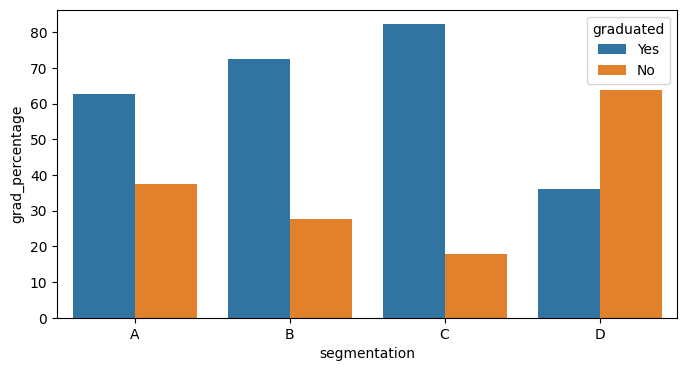

In [24]:
plt.figure(figsize=(8, 4))
sns.barplot(x="segmentation", y="grad_percentage", hue="graduated", data=df_grad)

### Profession
* In Group D, the proportions of customer in healthcare and marketing are noticeably higher than in other groups.

In [25]:
def get_percentage_categorical_feature(df, feature):
    df_perc_cat = df[df[feature].notna()]
    df_count_segmentation = df_perc_cat.groupby(['segmentation']).agg(count_seg=('segmentation', 'count')).reset_index()
    
    df_perc_cat= df_perc_cat.groupby(['segmentation'])[feature].value_counts().reset_index()
    df_perc_cat = df_perc_cat.merge(df_count_segmentation, on=['segmentation'], how='left')
    df_perc_cat[f'{feature}_percentage'] = 100 * df_perc_cat['count'] / df_perc_cat['count_seg']
    
    return df_perc_cat

In [26]:
df_profession = get_percentage_categorical_feature(df_train, 'profession')

<Figure size 1000x600 with 0 Axes>

<Axes: xlabel='segmentation', ylabel='profession_percentage'>

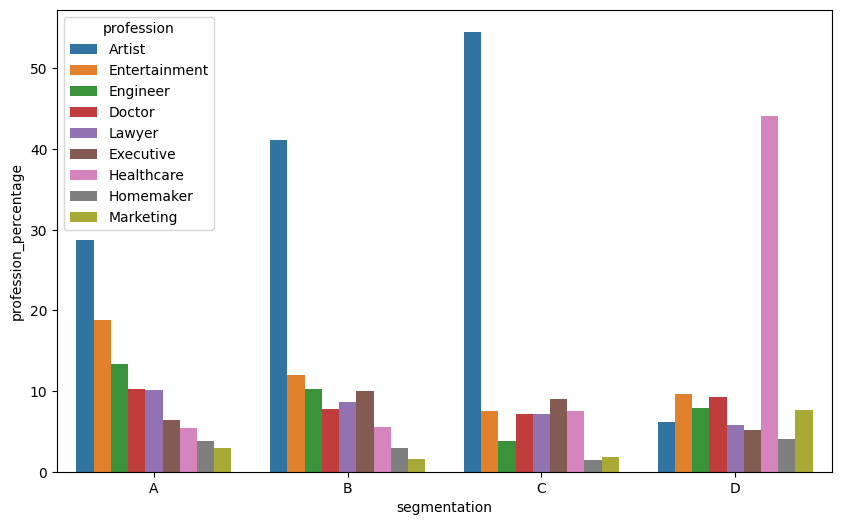

In [27]:
plt.figure(figsize=(10, 6))
sns.barplot(x="segmentation", y="profession_percentage", hue="profession", data=df_profession)

### Work experience
* There is no difference between the groups.

In [28]:
df_train['work_experience'].value_counts()

work_experience
1.0     2354
0.0     2318
9.0      474
8.0      463
2.0      286
3.0      255
4.0      253
6.0      204
7.0      196
5.0      194
10.0      53
11.0      50
12.0      48
13.0      46
14.0      45
Name: count, dtype: int64

In [29]:
df_work = df_train.groupby('segmentation')['work_experience'].median().reset_index()
df_work

df_work = df_train.groupby('segmentation')['work_experience'].mean().reset_index()
df_work

,segmentation,work_experience
0,A,1.0
1,B,1.0
2,C,1.0
3,D,1.0


,segmentation,work_experience
0,A,2.874578
1,B,2.378151
2,C,2.240771
3,D,3.021717


In [30]:
df_work_exp = get_percentage_categorical_feature(df_train, 'work_experience')

<Figure size 1000x600 with 0 Axes>

<Axes: xlabel='segmentation', ylabel='work_experience_percentage'>

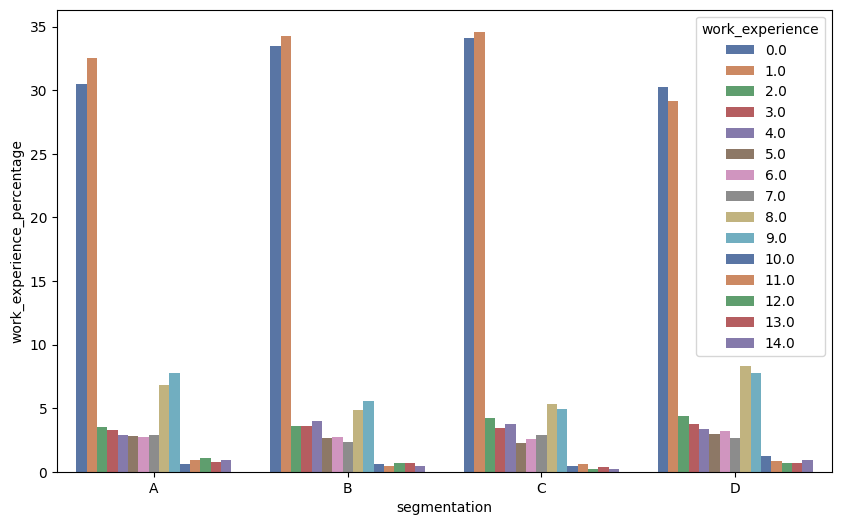

In [31]:
plt.figure(figsize=(10, 6))
sns.barplot(x="segmentation", y="work_experience_percentage", hue="work_experience", data=df_work_exp, palette='deep')

### Spending score
* Group C has a relatively higher average proportion compared to other groups, while Group D has a significantly higher proportion of "low" compared to the other groups.

In [32]:
df_spend = get_percentage_categorical_feature(df_train, 'spending_score')

In [33]:
df_spend

,segmentation,spending_score,count,count_seg,spending_score_percentage
0,A,Low,1358,1972,68.864097
1,A,Average,343,1972,17.393509
2,A,High,271,1972,13.742394
3,B,Low,884,1858,47.578041
4,B,Average,590,1858,31.754575
5,B,High,384,1858,20.667384
6,C,Average,903,1970,45.837563
7,C,Low,662,1970,33.604061
8,C,High,405,1970,20.558376
9,D,Low,1974,2268,87.037037


<Figure size 1000x600 with 0 Axes>

<Axes: xlabel='segmentation', ylabel='spending_score_percentage'>

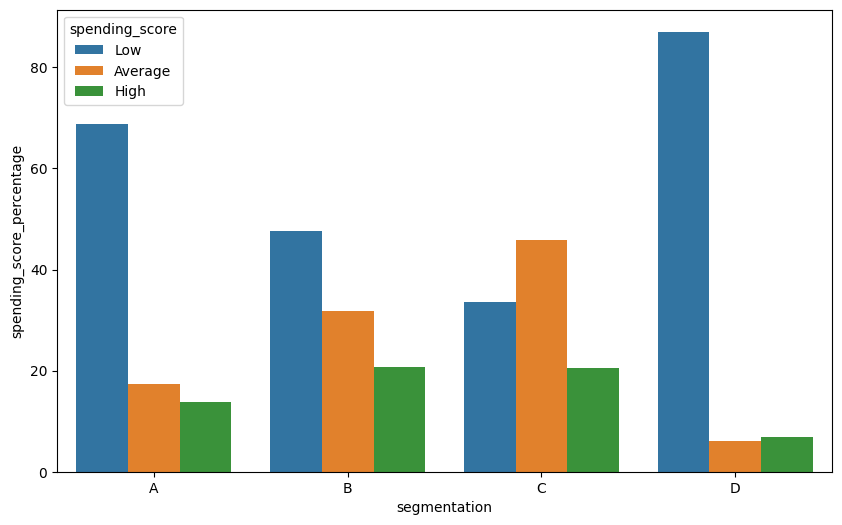

In [34]:
plt.figure(figsize=(10, 6))
sns.barplot(x="segmentation", y="spending_score_percentage", hue="spending_score", data=df_spend)

<Figure size 1000x600 with 0 Axes>

<Axes: xlabel='spending_score', ylabel='spending_score_percentage'>

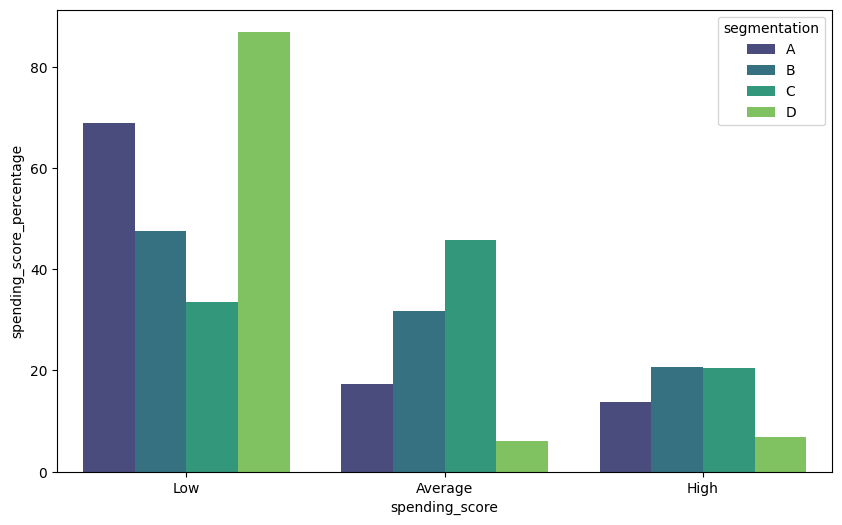

In [35]:
plt.figure(figsize=(10, 6))
sns.barplot(x="spending_score", y="spending_score_percentage", hue="segmentation", data=df_spend, palette='viridis')

### Family size
* Group C has a smaller proportion of size 1 compared to other groups. 
* Group D has a higher proportion of size 2 compared to the other groups.

In [36]:
df_fam = get_percentage_categorical_feature(df_train, 'family_size')

<Figure size 1000x600 with 0 Axes>

<Axes: xlabel='segmentation', ylabel='family_size_percentage'>

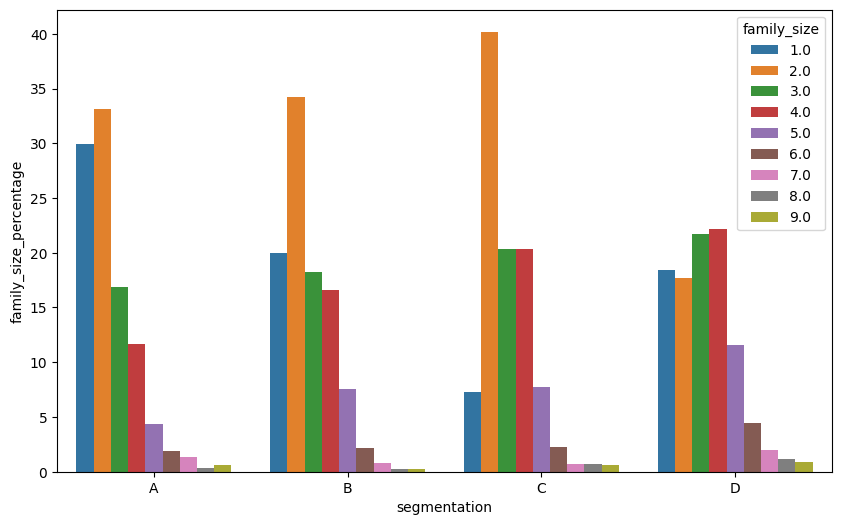

In [37]:
plt.figure(figsize=(10, 6))
sns.barplot(x="segmentation", y="family_size_percentage", hue="family_size", data=df_fam)

<Figure size 1000x600 with 0 Axes>

<Axes: xlabel='family_size', ylabel='family_size_percentage'>

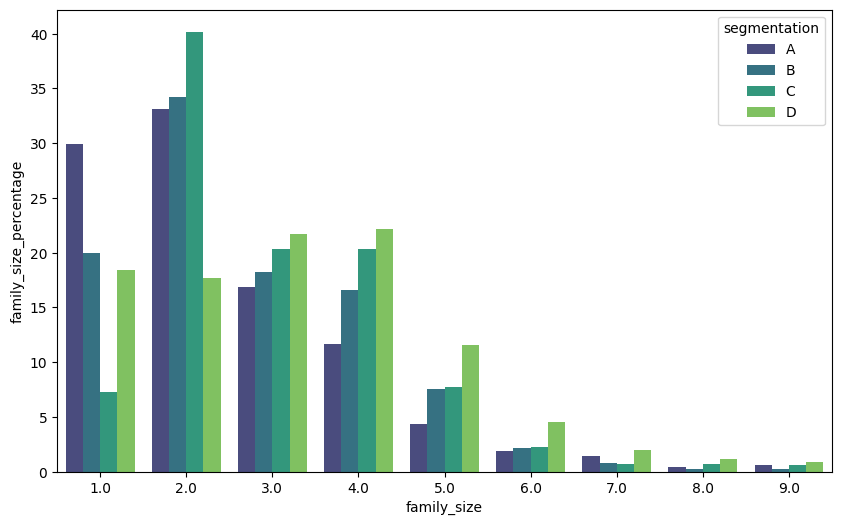

In [38]:
plt.figure(figsize=(10, 6))
sns.barplot(x="family_size", y="family_size_percentage", hue="segmentation", data=df_fam, palette='viridis')

### var_1

In [39]:
df_var_1 = get_percentage_categorical_feature(df_train, 'var_1')

<Figure size 1000x600 with 0 Axes>

<Axes: xlabel='segmentation', ylabel='var_1_percentage'>

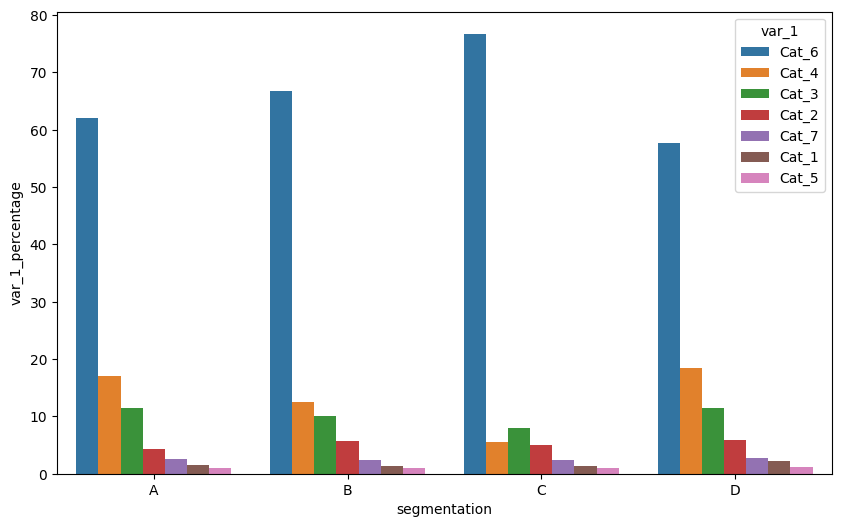

In [40]:
plt.figure(figsize=(10, 6))
sns.barplot(x="segmentation", y="var_1_percentage", hue="var_1", data=df_var_1)

<Figure size 1000x600 with 0 Axes>

<Axes: xlabel='var_1', ylabel='var_1_percentage'>

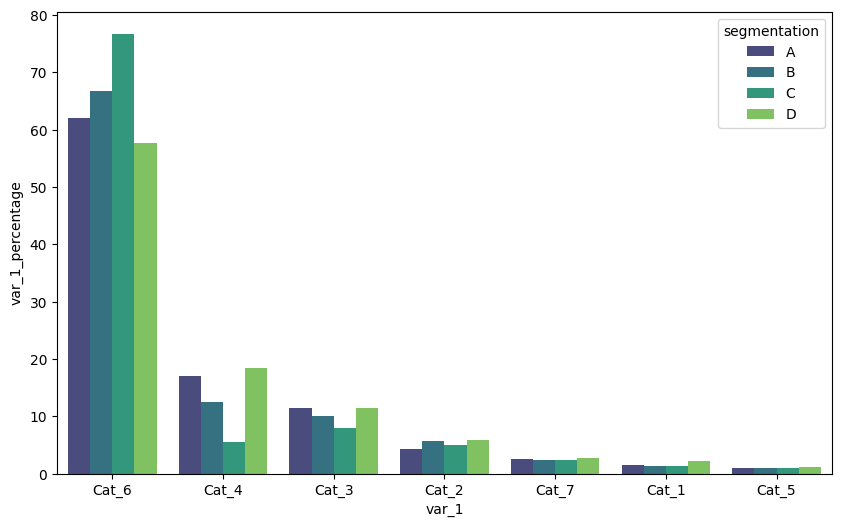

In [41]:
plt.figure(figsize=(10, 6))
sns.barplot(x="var_1", y="var_1_percentage", hue="segmentation", data=df_var_1, palette='viridis')

# Modeling

## LightGBM

### Version 1 : raw feature

In [42]:
df_train = pd.read_csv('customer_segmentation_train.csv')
df_test = pd.read_csv('customer_segmentation_test.csv')

In [43]:
df_train_set = df_train.copy()

In [44]:
df_train_set.dtypes

id                   int64
gender              object
ever_married        object
age                  int64
graduated           object
profession          object
work_experience    float64
spending_score      object
family_size        float64
var_1               object
segmentation        object
dtype: object

In [45]:
# Determine feature
CAT_COLS = ['gender', 'ever_married', 'graduated', 'profession', 'spending_score', 'var_1']
NUM_COLS = ['age', 'work_experience', 'family_size']

cat_cols = [col for col in df_train_set.columns if col in CAT_COLS]
num_cols = [col for col in df_train_set.columns if col in NUM_COLS]
feature_cols = num_cols + cat_cols

# Change category columns type
for col in cat_cols:
    df_train_set[col] = df_train_set[col].astype('category')

# Split feature and target
x = df_train_set[feature_cols]
y = df_train_set['segmentation']

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = 0.2, random_state = 42)

In [46]:
lgbm_model = lightgbm.LGBMClassifier(boosting_type='gbdt',
                                num_leaves = 31,
                                learning_rate = 0.01,
                                n_estimators=100,
                                objective='multiclass',
                                importance_type='split'
                               )
lgbm_model.fit(x_train, y_train)

LGBMClassifier(learning_rate=0.01, objective='multiclass')

In [47]:
y_pred_train = lgbm_model.predict(x_train)
train_accuracy = accuracy_score(y_pred_train, y_train)

y_pred_val = lgbm_model.predict(x_val)
test_accuracy = accuracy_score(y_pred_val, y_val)

print(f"Train accuracy : {train_accuracy}")
print(f"Test accuracy : {test_accuracy}")

Train accuracy : 0.582739386427022
Test accuracy : 0.5192069392812887


In [48]:
print(classification_report(y_val, y_pred_val))

              precision    recall  f1-score   support

           A       0.41      0.43      0.42       391
           B       0.41      0.27      0.33       369
           C       0.52      0.54      0.53       380
           D       0.65      0.76      0.70       474

    accuracy                           0.52      1614
   macro avg       0.50      0.50      0.50      1614
weighted avg       0.51      0.52      0.51      1614



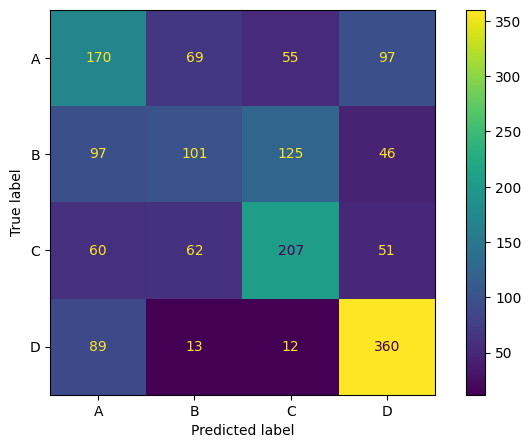

In [49]:
# Plot confusion matrix
fig, ax = plt.subplots(figsize=(8, 5))
cmp = ConfusionMatrixDisplay(
    confusion_matrix(y_val, y_pred_val),
    display_labels=["A", "B", "C", "D"],
)

cmp.plot(ax=ax)
plt.show();

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

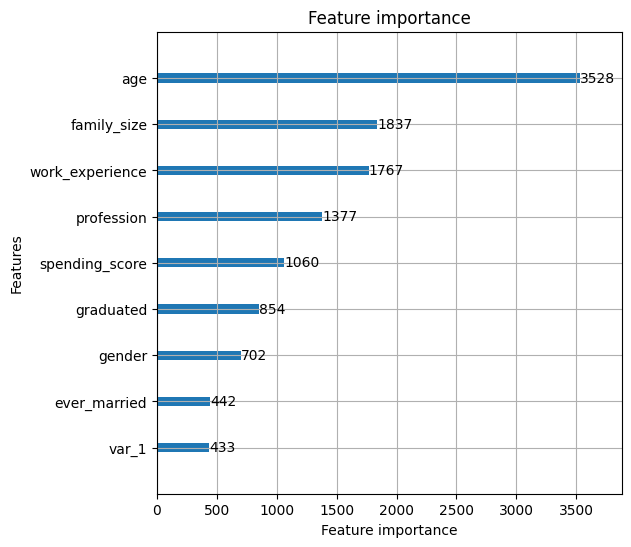

In [50]:
# Plot feature importances
lightgbm.plot_importance(lgbm_model, figsize=(6, 6))

### Version 2 : remove feature

In [51]:
df_train = pd.read_csv('customer_segmentation_train.csv')
df_test = pd.read_csv('customer_segmentation_test.csv')

In [52]:
df_train_set = df_train.copy()

In [53]:
# Determine feature
CAT_COLS = ['gender', 'ever_married', 'graduated', 'profession', 'spending_score', 'var_1']
NUM_COLS = []

cat_cols = [col for col in df_train_set.columns if col in CAT_COLS]
num_cols = [col for col in df_train_set.columns if col in NUM_COLS]
feature_cols = num_cols + cat_cols

# Change category columns type
for col in cat_cols:
    df_train_set[col] = df_train_set[col].astype('category')

# Split feature and target
x = df_train_set[feature_cols]
y = df_train_set['segmentation']

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = 0.2, random_state = 42)

In [54]:
model = lightgbm.LGBMClassifier(boosting_type='gbdt',
                                num_leaves = 31,
                                learning_rate = 0.01,
                                n_estimators=100,
                                objective='multiclass',
                                importance_type='split'
                               )
model.fit(x_train, y_train)

LGBMClassifier(learning_rate=0.01, objective='multiclass')

In [55]:
y_pred_train = model.predict(x_train)
train_accuracy = accuracy_score(y_pred_train, y_train)

y_pred_val = model.predict(x_val)
test_accuracy = accuracy_score(y_pred_val, y_val)

print(f"Train accuracy : {train_accuracy}")
print(f"Test accuracy : {test_accuracy}")

Train accuracy : 0.5320731329408119
Test accuracy : 0.4950433705080545


In [56]:
print(classification_report(y_val, y_pred_val))

              precision    recall  f1-score   support

           A       0.41      0.38      0.40       391
           B       0.35      0.26      0.30       369
           C       0.50      0.58      0.54       380
           D       0.62      0.70      0.66       474

    accuracy                           0.50      1614
   macro avg       0.47      0.48      0.47      1614
weighted avg       0.48      0.50      0.48      1614



<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

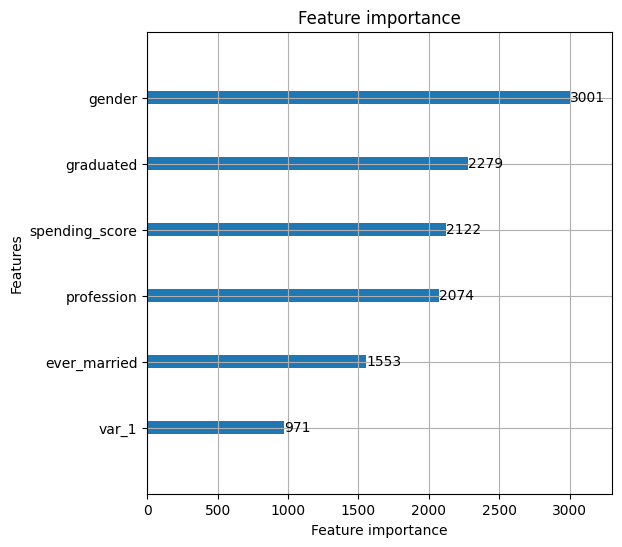

In [57]:
# Plot feature importances
lightgbm.plot_importance(model, figsize=(6, 6))

### Version 3 : feature engineering

In [58]:
df_train = pd.read_csv('customer_segmentation_train.csv')
df_test = pd.read_csv('customer_segmentation_test.csv')

In [59]:
df_train_set = df_train.copy()

In [60]:
# df_train_set = df_train_set[df_train_set['work_experience'].notna()]
# df_train_set = df_train_set[df_train_set['family_size'].notna()]

In [61]:
df_train_set['work_experience'].min()
df_train_set['work_experience'].max()

0.0

14.0

In [62]:
df_train_set['work_exp_ratio'] = df_train_set['work_experience'] / (df_train_set['age'] - 18)

df_train_set['age_diif_median_A'] = df_train_set['age'] - df_train_set[df_train_set['segmentation'] == 'A']['age'].median()
df_train_set['age_diif_median_B'] = df_train_set['age'] - df_train_set[df_train_set['segmentation'] == 'B']['age'].median()
df_train_set['age_diif_median_C'] = df_train_set['age'] - df_train_set[df_train_set['segmentation'] == 'C']['age'].median()
df_train_set['age_diif_median_D'] = df_train_set['age'] - df_train_set[df_train_set['segmentation'] == 'D']['age'].median()

df_train_set['work_diif_median_A'] = df_train_set['work_experience'] - df_train_set[df_train_set['segmentation'] == 'A']['work_experience'].median()
df_train_set['work_diif_median_B'] = df_train_set['work_experience'] - df_train_set[df_train_set['segmentation'] == 'B']['work_experience'].median()
df_train_set['work_diif_median_C'] = df_train_set['work_experience'] - df_train_set[df_train_set['segmentation'] == 'C']['work_experience'].median()
df_train_set['work_diif_median_D'] = df_train_set['work_experience'] - df_train_set[df_train_set['segmentation'] == 'D']['work_experience'].median()

In [63]:
df_train_set['have_kids'] = 'No'
df_train_set.loc[(df_train_set['ever_married'] == 'Yes') & (df_train_set['family_size'] >= 3), 'have_kids'] = 'Yes'

In [64]:
df_train_set.columns

Index(['id', 'gender', 'ever_married', 'age', 'graduated', 'profession',
       'work_experience', 'spending_score', 'family_size', 'var_1',
       'segmentation', 'work_exp_ratio', 'age_diif_median_A',
       'age_diif_median_B', 'age_diif_median_C', 'age_diif_median_D',
       'work_diif_median_A', 'work_diif_median_B', 'work_diif_median_C',
       'work_diif_median_D', 'have_kids'],
      dtype='object')

In [65]:
# Determine feature
CAT_COLS = ['gender', 'ever_married', 'graduated', 'profession', 'spending_score', 'var_1', 'have_kids']
NUM_COLS = ['age', 'work_experience', 'family_size',
            'age_diif_median_A', 'age_diif_median_B', 'age_diif_median_C', 'age_diif_median_D',
            'work_diif_median_A', 'work_diif_median_B', 'work_diif_median_C', 'work_diif_median_D']

cat_cols = [col for col in df_train_set.columns if col in CAT_COLS]
num_cols = [col for col in df_train_set.columns if col in NUM_COLS]
feature_cols = num_cols + cat_cols

# Change category columns type
for col in cat_cols:
    df_train_set[col] = df_train_set[col].astype('category')

# Split feature and target
x = df_train_set[feature_cols]
y = df_train_set['segmentation']

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = 0.2, random_state = 42)

In [66]:
model = lightgbm.LGBMClassifier(boosting_type='gbdt',
                                num_leaves = 31,
                                learning_rate = 0.01,
                                n_estimators=100,
                                objective='multiclass',
                                importance_type='split'
                               )
model.fit(x_train, y_train)

LGBMClassifier(learning_rate=0.01, objective='multiclass')

In [67]:
y_pred_train = model.predict(x_train)
train_accuracy = accuracy_score(y_pred_train, y_train)

y_pred_val = model.predict(x_val)
test_accuracy = accuracy_score(y_pred_val, y_val)

print(f"Train accuracy : {train_accuracy}")
print(f"Test accuracy : {test_accuracy}")

Train accuracy : 0.5824295010845987
Test accuracy : 0.5154894671623296


In [68]:
print(classification_report(y_val, y_pred_val))

              precision    recall  f1-score   support

           A       0.41      0.43      0.42       391
           B       0.41      0.27      0.33       369
           C       0.52      0.54      0.53       380
           D       0.64      0.75      0.69       474

    accuracy                           0.52      1614
   macro avg       0.49      0.50      0.49      1614
weighted avg       0.50      0.52      0.50      1614



<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

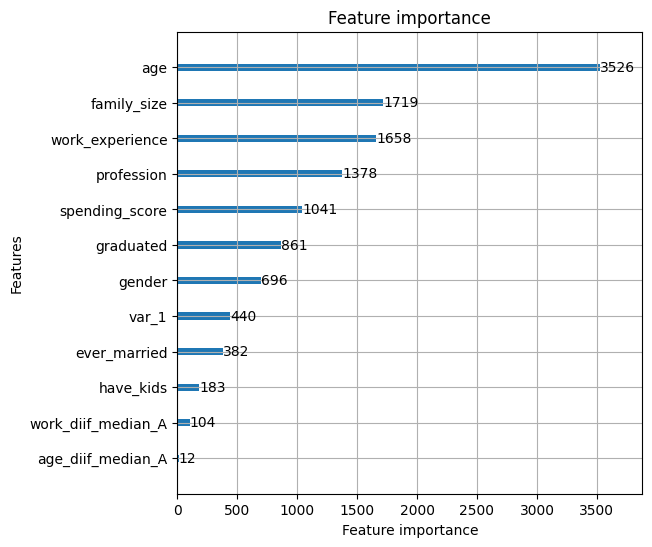

In [69]:
# Plot feature importances
lightgbm.plot_importance(model, figsize=(6, 6))

## Decision Tree

In [70]:
df_train = pd.read_csv('customer_segmentation_train.csv')
df_test = pd.read_csv('customer_segmentation_test.csv')

In [71]:
df_train_set = df_train.copy()

In [72]:
# Determine feature
CAT_COLS = ['gender', 'ever_married', 'graduated', 'profession', 'spending_score', 'var_1']
NUM_COLS = ['age', 'work_experience', 'family_size']

cat_cols = [col for col in df_train_set.columns if col in CAT_COLS]
num_cols = [col for col in df_train_set.columns if col in NUM_COLS]
feature_cols = num_cols + cat_cols

# Split feature and target
x = df_train_set[feature_cols]
y = df_train_set['segmentation']

In [73]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = 0.2, random_state = 42)

In [74]:
encoder = ce.OrdinalEncoder(cols=CAT_COLS)


x_train = encoder.fit_transform(x_train)
x_val = encoder.transform(x_val)

In [75]:
clf_gini = DecisionTreeClassifier(criterion='gini', max_depth=3, random_state=42)

In [76]:
x_train.isna().sum()

age                  0
work_experience    659
family_size        260
gender               0
ever_married         0
graduated            0
profession           0
spending_score       0
var_1                0
dtype: int64

In [77]:
x_train['work_experience'] = x_train['work_experience'].fillna(x_train['work_experience'].median())
x_train['family_size'] = x_train['family_size'].fillna(x_train['family_size'].median())

In [78]:
clf_gini.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=42)

In [79]:
x_val['work_experience'] = x_val['work_experience'].fillna(x_val['work_experience'].median())
x_val['family_size'] = x_val['family_size'].fillna(x_val['family_size'].median())

In [80]:
y_pred_train = clf_gini.predict(x_train)
train_accuracy = accuracy_score(y_pred_train, y_train)

y_pred_val = clf_gini.predict(x_val)
test_accuracy = accuracy_score(y_pred_val, y_val)

print(f"Train accuracy : {train_accuracy}")
print(f"Test accuracy : {test_accuracy}")

Train accuracy : 0.496436318562132
Test accuracy : 0.49008674101610905


In [81]:
print(classification_report(y_val, y_pred_val))

              precision    recall  f1-score   support

           A       0.37      0.40      0.39       391
           B       0.40      0.17      0.24       369
           C       0.49      0.54      0.51       380
           D       0.60      0.77      0.67       474

    accuracy                           0.49      1614
   macro avg       0.46      0.47      0.45      1614
weighted avg       0.47      0.49      0.47      1614



## SVM

In [82]:
df_train = pd.read_csv('customer_segmentation_train.csv')
df_test = pd.read_csv('customer_segmentation_test.csv')

df_train_set = df_train.copy()

In [83]:
# Determine feature
CAT_COLS = ['gender', 'ever_married', 'graduated', 'profession', 'spending_score', 'var_1']
NUM_COLS = ['age', 'work_experience', 'family_size']

cat_cols = [col for col in df_train_set.columns if col in CAT_COLS]
num_cols = [col for col in df_train_set.columns if col in NUM_COLS]
feature_cols = num_cols + cat_cols

# Split feature and target
x = df_train_set[feature_cols]
y = df_train_set['segmentation']

In [84]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = 0.2, random_state = 42)

In [85]:
encoder = ce.OrdinalEncoder(cols=CAT_COLS)


x_train = encoder.fit_transform(x_train)
x_val = encoder.transform(x_val)

In [86]:
x_train['work_experience'] = x_train['work_experience'].fillna(x_train['work_experience'].median())
x_train['family_size'] = x_train['family_size'].fillna(x_train['family_size'].median())

x_val['work_experience'] = x_val['work_experience'].fillna(x_val['work_experience'].median())
x_val['family_size'] = x_val['family_size'].fillna(x_val['family_size'].median())

In [87]:
# Create an SVM model for multiclass classification
svm_model = SVC(kernel='linear', C=1.0, decision_function_shape='ovr')  # One-vs-Rest strategy

# Train the model
svm_model.fit(x_train, y_train)

SVC(kernel='linear')

In [88]:
y_pred_train = svm_model.predict(x_train)
train_accuracy = accuracy_score(y_pred_train, y_train)

y_pred_val =  svm_model.predict(x_val)
test_accuracy = accuracy_score(y_pred_val, y_val)

print(f"Train accuracy : {train_accuracy}")
print(f"Test accuracy : {test_accuracy}")

Train accuracy : 0.4727300898667493
Test accuracy : 0.4541511771995043


In [89]:
print(classification_report(y_val, y_pred_val))

              precision    recall  f1-score   support

           A       0.35      0.44      0.39       391
           B       0.35      0.08      0.13       369
           C       0.41      0.59      0.49       380
           D       0.62      0.65      0.63       474

    accuracy                           0.45      1614
   macro avg       0.43      0.44      0.41      1614
weighted avg       0.44      0.45      0.42      1614



## AutoML

In [90]:
df_train = pd.read_csv('customer_segmentation_train.csv')
df_test = pd.read_csv('customer_segmentation_test.csv')

In [91]:
df_train_set = df_train.copy()

In [92]:
# Determine feature
CAT_COLS = ['gender', 'ever_married', 'graduated', 'profession', 'spending_score', 'var_1']
NUM_COLS = ['age', 'work_experience', 'family_size']

cat_cols = [col for col in df_train_set.columns if col in CAT_COLS]
num_cols = [col for col in df_train_set.columns if col in NUM_COLS]
feature_cols = num_cols + cat_cols

# Split feature and target
x = df_train_set[feature_cols]
y = df_train_set['segmentation']

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = 0.2, random_state = 42)

In [93]:
x_train['segmentation'] = y_train
x_val['segmentation'] = y_val

In [94]:
%%time
predictor = TabularPredictor(label='segmentation').fit(x_train, verbosity=0)

No path specified. Models will be saved in: "AutogluonModels/ag-20230830_102840/"
Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
Could not infer format, so each element will be parsed individu

CPU times: user 1min 52s, sys: 3.4 s, total: 1min 55s
Wall time: 31.1 s


### Leaderboard

In [95]:
predictor.leaderboard(x_val, silent=True).sort_values(by='score_val', ascending=False)

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,0.532838,0.572755,0.198851,0.106396,10.356892,0.005179,0.000511,0.441776,2,True,14
3,CatBoost,0.526642,0.552632,0.013523,0.005334,4.017658,0.013523,0.005334,4.017658,1,True,8
4,XGBoost,0.526642,0.552632,0.035070,0.007383,0.745192,0.035070,0.007383,0.745192,1,True,11
5,NeuralNetTorch,0.522305,0.549536,0.016699,0.010039,13.761919,0.016699,0.010039,13.761919,1,True,12
2,LightGBMXT,0.527261,0.547988,0.010190,0.005122,1.067875,0.010190,0.005122,1.067875,1,True,4
1,NeuralNetFastAI,0.532218,0.540248,0.030562,0.012947,4.200085,0.030562,0.012947,4.200085,1,True,3
6,LightGBM,0.519207,0.540248,0.007201,0.003978,0.737318,0.007201,0.003978,0.737318,1,True,5
7,LightGBMLarge,0.508055,0.532508,0.020723,0.007205,2.253154,0.020723,0.007205,2.253154,1,True,13
11,RandomForestEntr,0.493185,0.495356,0.179868,0.087177,0.618275,0.179868,0.087177,0.618275,1,True,7
10,RandomForestGini,0.495663,0.492260,0.200340,0.095645,0.610601,0.200340,0.095645,0.610601,1,True,6


In [96]:
y_pred_val = predictor.predict(x_val.drop(columns=['segmentation']), model='WeightedEnsemble_L2')

In [97]:
print(classification_report(y_val, y_pred_val))

              precision    recall  f1-score   support

           A       0.45      0.46      0.45       391
           B       0.41      0.38      0.40       369
           C       0.56      0.52      0.54       380
           D       0.67      0.72      0.69       474

    accuracy                           0.53      1614
   macro avg       0.52      0.52      0.52      1614
weighted avg       0.53      0.53      0.53      1614



In [98]:
y_pred_val = predictor.predict(x_val.drop(columns=['segmentation']), model='CatBoost')

In [99]:
print(classification_report(y_val, y_pred_val))

              precision    recall  f1-score   support

           A       0.43      0.48      0.45       391
           B       0.40      0.33      0.36       369
           C       0.54      0.53      0.53       380
           D       0.68      0.72      0.70       474

    accuracy                           0.53      1614
   macro avg       0.51      0.51      0.51      1614
weighted avg       0.52      0.53      0.52      1614



In [100]:
y_pred_val = predictor.predict(x_val.drop(columns=['segmentation']), model='XGBoost')

In [101]:
print(classification_report(y_val, y_pred_val))

              precision    recall  f1-score   support

           A       0.44      0.43      0.43       391
           B       0.41      0.32      0.36       369
           C       0.53      0.58      0.55       380
           D       0.65      0.73      0.69       474

    accuracy                           0.53      1614
   macro avg       0.51      0.51      0.51      1614
weighted avg       0.52      0.53      0.52      1614



## Diagnostic

In [102]:
df_train = pd.read_csv('customer_segmentation_train.csv')

In [103]:
df_train[df_train.drop(columns=['id', 'segmentation']).duplicated()]

,id,gender,ever_married,age,graduated,profession,work_experience,spending_score,family_size,var_1,segmentation
277,462075,Female,No,40,Yes,Artist,1.0,Low,1.0,Cat_6,B
319,459768,Male,No,19,No,Healthcare,0.0,Low,4.0,Cat_6,D
342,465192,Male,Yes,55,No,Artist,0.0,Low,1.0,Cat_6,A
540,459149,Male,Yes,43,No,Executive,0.0,High,4.0,Cat_6,B
572,459298,Male,Yes,45,Yes,Artist,4.0,Average,4.0,Cat_6,C
...,...,...,...,...,...,...,...,...,...,...,...
8026,466852,Female,No,23,No,Marketing,4.0,Low,4.0,Cat_6,C
8042,465422,Female,Yes,40,Yes,Artist,1.0,Average,2.0,Cat_6,C
8054,463437,Male,Yes,49,Yes,Artist,1.0,Average,3.0,Cat_6,B
8055,461291,Male,No,18,No,Healthcare,0.0,Low,2.0,Cat_6,D


In [104]:
df_feat_dup = df_train[df_train.drop(columns=['id', 'segmentation']).duplicated(keep=False)]
sort_index = list(df_feat_dup.drop(columns=['id', 'segmentation']).columns)
df_feat_dup = df_feat_dup.sort_values(by=sort_index)

In [105]:
df_feat_dup.tail(50)

,id,gender,ever_married,age,graduated,profession,work_experience,spending_score,family_size,var_1,segmentation
147,461740,Male,Yes,80,Yes,Lawyer,1.0,Low,1.0,Cat_6,B
1813,459159,Male,Yes,80,Yes,Lawyer,1.0,Low,1.0,Cat_6,A
4433,467019,Male,Yes,80,Yes,Lawyer,1.0,Low,1.0,Cat_6,C
4801,467113,Male,Yes,80,Yes,Lawyer,NaN,Low,1.0,Cat_6,D
5629,467293,Male,Yes,80,Yes,Lawyer,NaN,Low,1.0,Cat_6,D
4146,463010,Male,Yes,81,No,Executive,0.0,Low,1.0,Cat_6,D
7783,465107,Male,Yes,81,No,Executive,0.0,Low,1.0,Cat_6,D
5199,459321,Male,Yes,81,Yes,Entertainment,1.0,Low,1.0,Cat_6,B
5721,466914,Male,Yes,81,Yes,Entertainment,1.0,Low,1.0,Cat_6,D
6748,459147,Male,Yes,81,Yes,Entertainment,1.0,Low,1.0,Cat_6,D


# Prediction

## CrossValidation

In [106]:
df_train = pd.read_csv('customer_segmentation_train.csv')

In [107]:
df_train_set = df_train.copy()

In [108]:
# Determine feature
CAT_COLS = ['gender', 'ever_married', 'graduated', 'profession', 'spending_score', 'var_1']
NUM_COLS = ['age', 'work_experience', 'family_size']

cat_cols = [col for col in df_train_set.columns if col in CAT_COLS]
num_cols = [col for col in df_train_set.columns if col in NUM_COLS]
feature_cols = num_cols + cat_cols

# Change category columns type
for col in cat_cols:
    df_train_set[col] = df_train_set[col].astype('category')

# Split feature and target
x = df_train_set[feature_cols + ['segmentation']]
y = df_train_set['segmentation']

In [109]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

accuracy_scores = []
df_fold_result = pd.DataFrame()

for fold_, (train_index, val_index) in enumerate(skf.split(x, y)):
    x_train, x_val = x.iloc[train_index], x.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    

    predictor = TabularPredictor(label='segmentation').fit(x_train, hyperparameters={'XGB':{}}, verbosity=0)
    y_pred_val = predictor.predict(x_val.drop(columns=['segmentation']), model='XGBoost')
    
    # Calculate accuracy for this fold
    accuracy = accuracy_score(y_val, y_pred_val)
    
    df_fold_result_tmp = pd.DataFrame({
        'fold': [fold_ + 1],
        'accuracy': [accuracy]
    })
    
    df_fold_result = pd.concat([df_fold_result, df_fold_result_tmp])


No path specified. Models will be saved in: "AutogluonModels/ag-20230830_102913/"
No path specified. Models will be saved in: "AutogluonModels/ag-20230830_102914/"
No path specified. Models will be saved in: "AutogluonModels/ag-20230830_102915/"
No path specified. Models will be saved in: "AutogluonModels/ag-20230830_102916/"
No path specified. Models will be saved in: "AutogluonModels/ag-20230830_102916-001/"


In [110]:
df_fold_result
print(f"Average Accuracy: {df_fold_result['accuracy'].mean()}")

,fold,accuracy
0,1,0.529740
0,2,0.522924
0,3,0.543990
0,4,0.530068
0,5,0.522009


Average Accuracy: 0.5297462300960827


## Predict

### Fit model with full data

In [111]:
df_train = pd.read_csv('customer_segmentation_train.csv')
df_test = pd.read_csv('customer_segmentation_test.csv')

In [112]:
df_train_set = df_train.copy()
df_test_set = df_test.copy()

In [113]:
# Determine feature
CAT_COLS = ['gender', 'ever_married', 'graduated', 'profession', 'spending_score', 'var_1']
NUM_COLS = ['age', 'work_experience', 'family_size']

cat_cols = [col for col in df_train_set.columns if col in CAT_COLS]
num_cols = [col for col in df_train_set.columns if col in NUM_COLS]
feature_cols = num_cols + cat_cols

# Change category columns type
for col in cat_cols:
    df_train_set[col] = df_train_set[col].astype('category')
    
# Change category columns type
for col in cat_cols:
    df_test_set[col] = df_test_set[col].astype('category')

# Split feature and target
x_train = df_train_set[feature_cols + ['segmentation']]
y_train = df_train_set['segmentation']

# Split feature and target
x_test = df_test_set[feature_cols]

In [114]:
predictor = TabularPredictor(label='segmentation').fit(x_train, hyperparameters={'XGB':{}}, verbosity=0)

No path specified. Models will be saved in: "AutogluonModels/ag-20230830_102917/"


In [115]:
y_pred_train = predictor.predict(x_train.drop(columns=['segmentation']), model='XGBoost')
train_accuracy = accuracy_score(y_train, y_pred_train)
print(f"Train accuracy : {train_accuracy}")

Train accuracy : 0.6933564700049578


### Predict test set

In [116]:
y_pred_test = predictor.predict(x_test, model='XGBoost')

In [117]:
y_pred_test.shape

(2627,)

In [118]:
df_submission = df_test_set.copy()
df_submission['segmentation'] = pd.Series(y_pred_test)
df_submission = df_submission[['id', 'segmentation']]

In [119]:
df_submission

,id,segmentation
0,458989,B
1,458994,C
2,458996,A
3,459000,C
4,459001,D
...,...,...
2622,467954,D
2623,467958,A
2624,467960,A
2625,467961,B


In [120]:
df_submission.to_csv('submission.csv', index=False)

# Model Explain

In [121]:
df_train = pd.read_csv('customer_segmentation_train.csv')
df_test = pd.read_csv('customer_segmentation_test.csv')

df_train_set = df_train.copy()

# Determine feature
CAT_COLS = ['gender', 'ever_married', 'graduated', 'profession', 'spending_score', 'var_1']
NUM_COLS = ['age', 'work_experience', 'family_size']

cat_cols = [col for col in df_train_set.columns if col in CAT_COLS]
num_cols = [col for col in df_train_set.columns if col in NUM_COLS]
feature_cols = num_cols + cat_cols

# Split feature and target
x = df_train_set[feature_cols]
y = df_train_set['segmentation']

# Encode vairable
encoder = ce.OrdinalEncoder(cols=CAT_COLS)
x = encoder.fit_transform(x)

target_map = {'A':0, 'B':1, 'C':2, 'D':3}
y = y.map(target_map)


# Fit model
xgb_model = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=4
)

xgb_model.fit(x, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_class=4,
              num_parallel_tree=None, objective='multi:softmax', ...)

In [122]:
# compute SHAP values
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(x)

## Feature importance

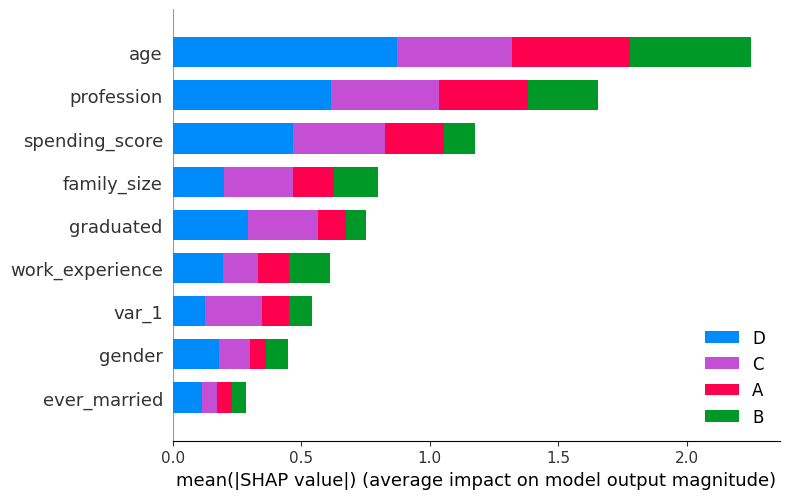

In [123]:
class_names = ['A', 'B', 'C', 'D']

shap.summary_plot(shap_values, x.values, plot_type="bar", class_names= class_names, feature_names = x.columns)

Class A


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


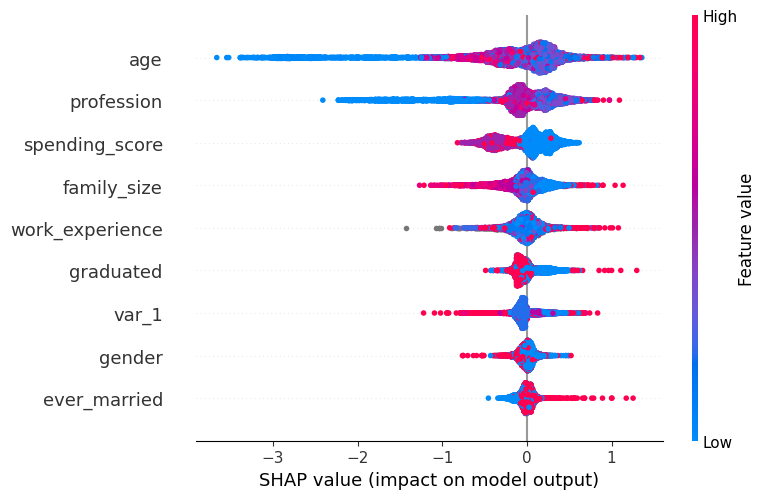



Class B


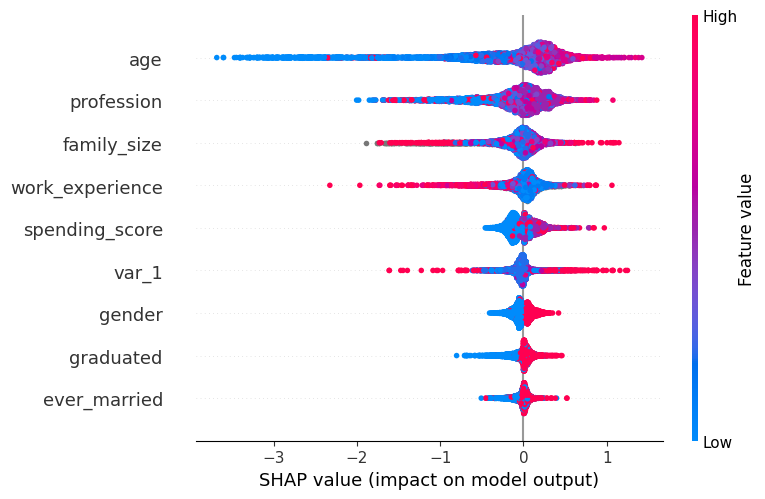



Class C


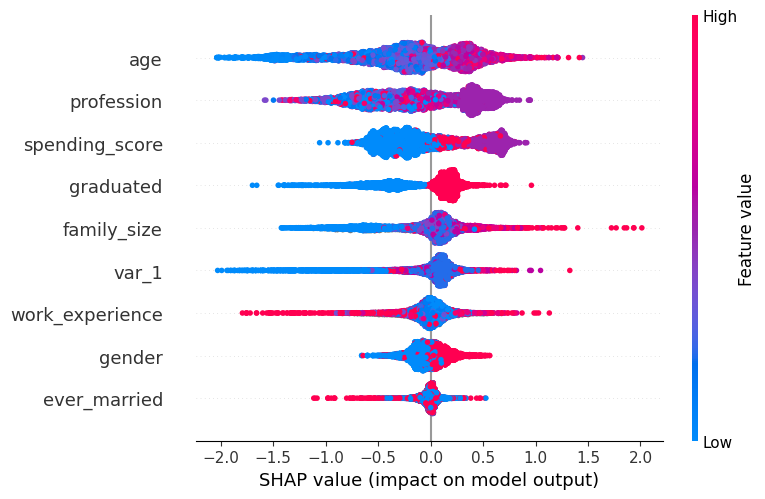



Class D


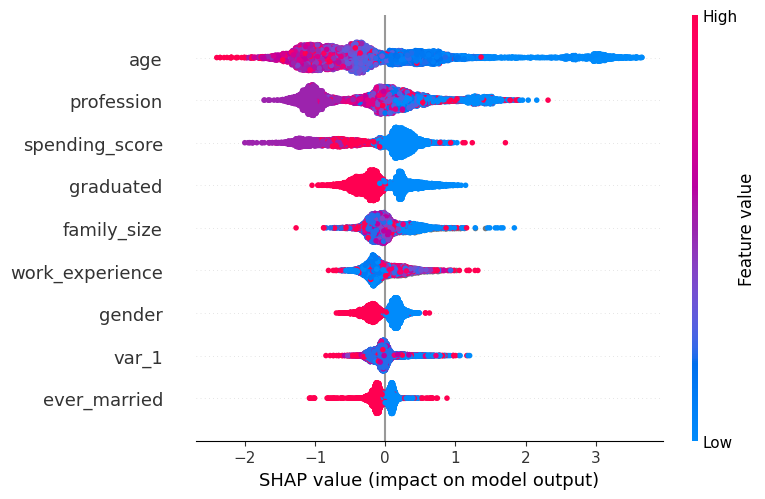

In [124]:
print('Class A')
shap.summary_plot(shap_values[0], x.values, feature_names = x.columns)


print('\n')
print('Class B')
shap.summary_plot(shap_values[1], x.values, feature_names = x.columns)

print('\n')
print('Class C')
shap.summary_plot(shap_values[2], x.values, feature_names = x.columns)

print('\n')
print('Class D')
shap.summary_plot(shap_values[3], x.values, feature_names = x.columns)

## Specific customer

In [125]:
person = 1
index = person-1

In [126]:
df_train[index:person]

,id,gender,ever_married,age,graduated,profession,work_experience,spending_score,family_size,var_1,segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D


In [127]:
shap.initjs()

target_class = 0
shap.force_plot(explainer.expected_value[0], shap_values[target_class][index], x.values[index], feature_names = x.columns)

In [128]:
shap.initjs()

target_class = 1
shap.force_plot(explainer.expected_value[0], shap_values[target_class][index], x.values[index], feature_names = x.columns)

In [129]:
shap.initjs()

target_class = 2
shap.force_plot(explainer.expected_value[0], shap_values[target_class][index], x.values[index], feature_names = x.columns)

In [130]:
shap.initjs()

target_class = 3
shap.force_plot(explainer.expected_value[0], shap_values[target_class][index], x.values[index], feature_names = x.columns)